### Forecast de demanda: Facturapp

#### ✅ SARIMA

1) Datos

In [2]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [3]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [4]:
# Asegúrate de que 'monto_ventas_producto' sea numérico
ventas_df['monto_ventas_producto'] = pd.to_numeric(ventas_df['cantidad_ventas_producto'], errors='coerce')

# Agrupa por tipo de moneda y suma los montos de ventas
suma_por_moneda = ventas_df.groupby('moneda_venta')['cantidad_ventas_producto'].sum()

# Calcular el total de todas las ventas
total_ventas = suma_por_moneda.sum()

# Crear un nuevo DataFrame con los montos y los porcentajes
resultado = pd.DataFrame({
    'Monto Total': suma_por_moneda,
    'Porcentaje del Total': (suma_por_moneda / total_ventas) * 100
})

# Formatear los montos y porcentajes para mejor legibilidad
resultado['Monto Total'] = resultado['Monto Total'].apply(lambda x: f"{x:,.2f}")
resultado['Porcentaje del Total'] = resultado['Porcentaje del Total'].apply(lambda x: f"{x:.2f}%")

# Verificar el resultado
resultado

,Monto Total,Porcentaje del Total
moneda_venta,,
$,"1,460,236.00",99.99%
U$S,140.00,0.01%


In [5]:
# Filtrar por tipo de moneda (por ejemplo, solo $)
ventas_filtrado = ventas_df.loc[ventas_df['moneda_venta'] == '$  ']

# Crear la tabla agregada con el DataFrame filtrado
df = ventas_filtrado.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que Prophet tome como input
df = df.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})

# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Revisar los datos resampleados
df.head()

,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


#### SARIMA

Datos de training:  550  -  82.0 %
Datos de testing:  119  -  18.0 %


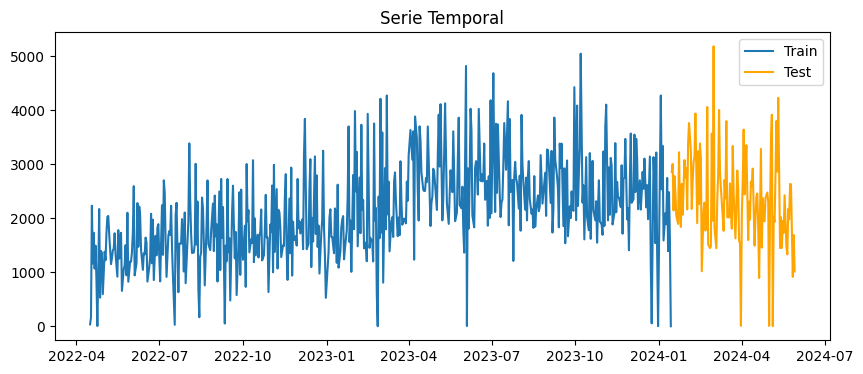

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Separación de datos
TEST_DATE = '2024-01-15'
df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]

print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)),2)*100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)),2)*100, "%")

# Plot serie temporal
plt.figure(figsize=(10, 4))
plt.plot(df_train['ds'], df_train['y'], label='Train')
plt.plot(df_test['ds'], df_test['y'], label='Test', color='orange')
plt.legend()
plt.title("Serie Temporal")
plt.show()

##### Prueba de estacionariedad con ADF

Realizamos la prueba Augmented Dickey-Fuller para verificar si la serie es estacionaria.

In [7]:
# Prueba de estacionariedad ADF
result = adfuller(df_train['y'])
print("p-value:", result[1])

# Si no es estacionaria, aplicar diferenciación
df_train_diff = df_train['y'].diff().dropna()

# Verificar de nuevo
result_diff = adfuller(df_train_diff)
print("p-value (differenced):", result_diff[1])

p-value: 0.15758583630208334
p-value (differenced): 3.1736492668764306e-15


##### Análisis ACF y PACF

Generamos gráficos de ACF y PACF para identificar valores preliminares de p y q.

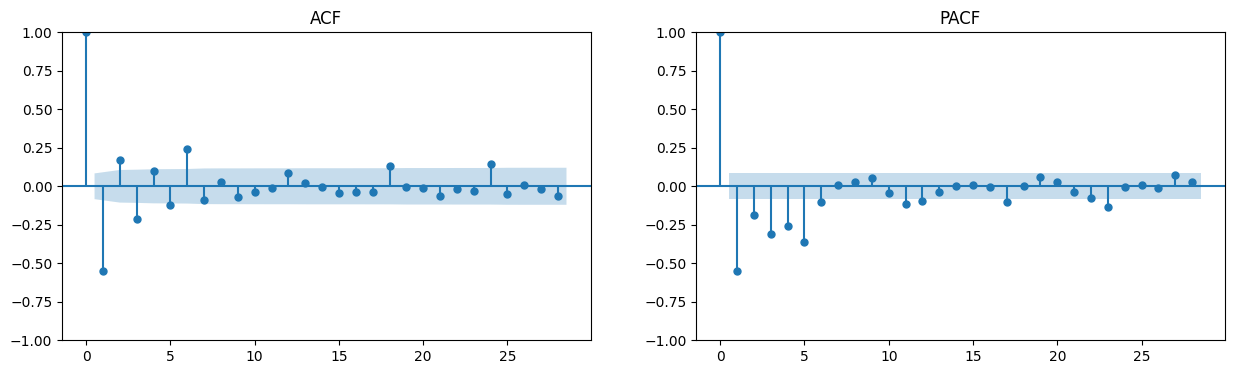

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_train_diff, ax=axes[0], title='ACF')
plot_pacf(df_train_diff, ax=axes[1], title='PACF')
plt.show()

##### Análisis de los componentes

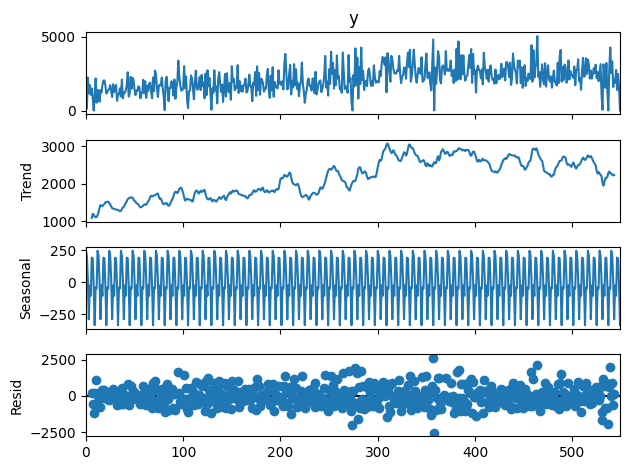

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Asegúrate de que los datos estén indexados por fecha
#df_train.set_index('ds', inplace=True)

# Descomponer los datos
result = seasonal_decompose(df_train['y'], model='additive', period=12)  # Usa 'multiplicative' si hay variaciones proporcionales

# Crear una figura personalizada y graficar los componentes
#fig, ax = plt.subplots(figsize=(12, 8))  # Ajusta el tamaño de la figura
result.plot()  # `ax` no es necesario en este caso, solo preparamos el espacio
plt.show()

# Volver a resetear el índice (opcional si lo necesitas en otro código)
df_train.reset_index(inplace=True)

##### Ajuste del modelo

In [11]:
from pmdarima import auto_arima

# Configurar auto_arima
stepwise_model = auto_arima(
    df_train['y'],
    seasonal=True,
    m=12,  # Frecuencia estacional (mensual)
    trace=True,  # Mostrar el proceso en la consola
    error_action='ignore',  # Ignorar errores
    suppress_warnings=True,  # Evitar warnings
    stepwise=True  # Búsqueda paso a paso
)

# Mostrar los mejores parámetros encontrados
print(stepwise_model.summary())

# Extraer los mejores parámetros
best_params = stepwise_model.get_params()
print("Mejores parámetros:", best_params)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8789.883, Time=8.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9212.655, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8999.701, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8825.478, Time=2.79 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9210.656, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8818.399, Time=4.21 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8814.028, Time=3.89 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8788.688, Time=14.34 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8791.979, Time=9.64 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=8789.551, Time=15.32 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8789.081, Time=14.06 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=8787.873, Time=13.98 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=8789.151, Time=4.55 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=8790.756, Time=8.94 sec
 ARIMA(1,1,2)(2

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  550
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -4189.812
Date:                              Sun, 26 Jan 2025   AIC                           8393.624
Time:                                      18:59:30   BIC                           8423.454
Sample:                                           0   HQIC                          8405.306
                                              - 550                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8130      0.117     -6.928      0.000      -1.043      -0.583
ma.L1         -0.25

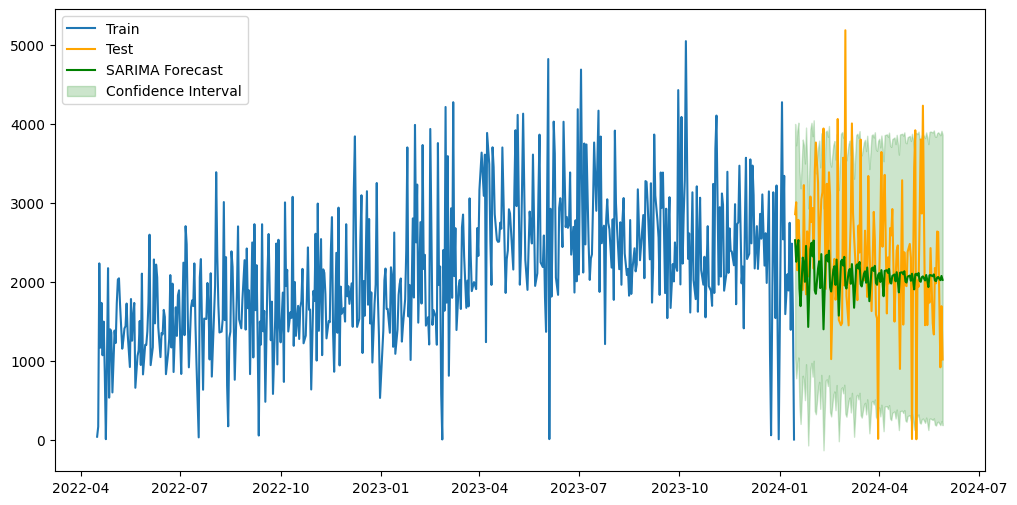

In [16]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Definir los parámetros iniciales para SARIMA
#p, d, q = 1, 1, 1
#P, D, Q, s = 1, 1, 1, 12  # Periodo mensual

p, d, q = 1, 1, 2
P, D, Q, s = 2, 0, 1, 12  # Periodo mensual
#'order': (1, 1, 2), 'seasonal_order': (2, 0, 1, 12)

# Ajustar el modelo SARIMA
model = SARIMAX(df_train['y'], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False, 
                enforce_invertibility=False)

sarima_fit = model.fit(disp=False)

# Resumen del modelo
print(sarima_fit.summary())

# Predicciones
forecast = sarima_fit.get_forecast(steps=len(df_test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Train')
plt.plot(df_test['ds'], df_test['y'], label='Test', color='orange')
plt.plot(df_test['ds'], forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(df_test['ds'], 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='green', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()


##### Métricas de evaluación

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

# Calcular métricas de evaluación
mae = mean_absolute_error(df_test['y'], forecast_mean)
rmse = np.sqrt(mean_squared_error(df_test['y'], forecast_mean))
mse = mean_squared_error(df_test['y'], forecast_mean)
mape = mean_absolute_percentage_error(df_test['y'], forecast_mean) * 100

print("=== Métricas de Evaluación ===")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")

=== Métricas de Evaluación ===
MAE (Error Absoluto Medio): 690.23
RMSE (Raíz del Error Cuadrático Medio): 924.65
MSE (Error Cuadrático Medio): 854982.32
MAPE (Error Porcentual Absoluto Medio): 597.06%
